### ▶️ Wir laden ein paar Python-Bibliotheken

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

### ▶️ Einlesen der vorbereiteten Daten aus dem Repository

- Die .csv-Datei beinhaltet die Klimadaten der Jahre 2021 bis 2024 für die Wetterstation Bamberg

In [277]:
# Importieren der .csv-Datei aus dem Projektverzeichnis
df = pd.read_csv('./Bamberg_Data.csv', parse_dates=['Zeitstempel'], index_col='Zeitstempel')

df.head()

,Wert,Kategorie,Station
Zeitstempel,,,
2021-01-01,2.0,Mittlere Temperatur,Bamberg
2021-01-02,1.1,Mittlere Temperatur,Bamberg
2021-01-03,0.9,Mittlere Temperatur,Bamberg
2021-01-04,1.3,Mittlere Temperatur,Bamberg
2021-01-05,2.0,Mittlere Temperatur,Bamberg


### ▶️ Prüfen ob die Zeitreihe stationär ist

- Dazu lassen wir einen ADFuller Test laufen

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Wert'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.278663
p-value: 0.178942
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


/tmp/ipykernel_37141/3357328779.py:3: FutureWarning: In a future version of pandas all arguments of Series.ffill will be keyword-only.
  result = adfuller(df['Wert'].ffill(0))


### ▶️ Entfernen von Trends aus der Zeitreihe

- Dazu erstellen wir Trendlinien und wählen die am besten passende

/home/dosmarcos/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


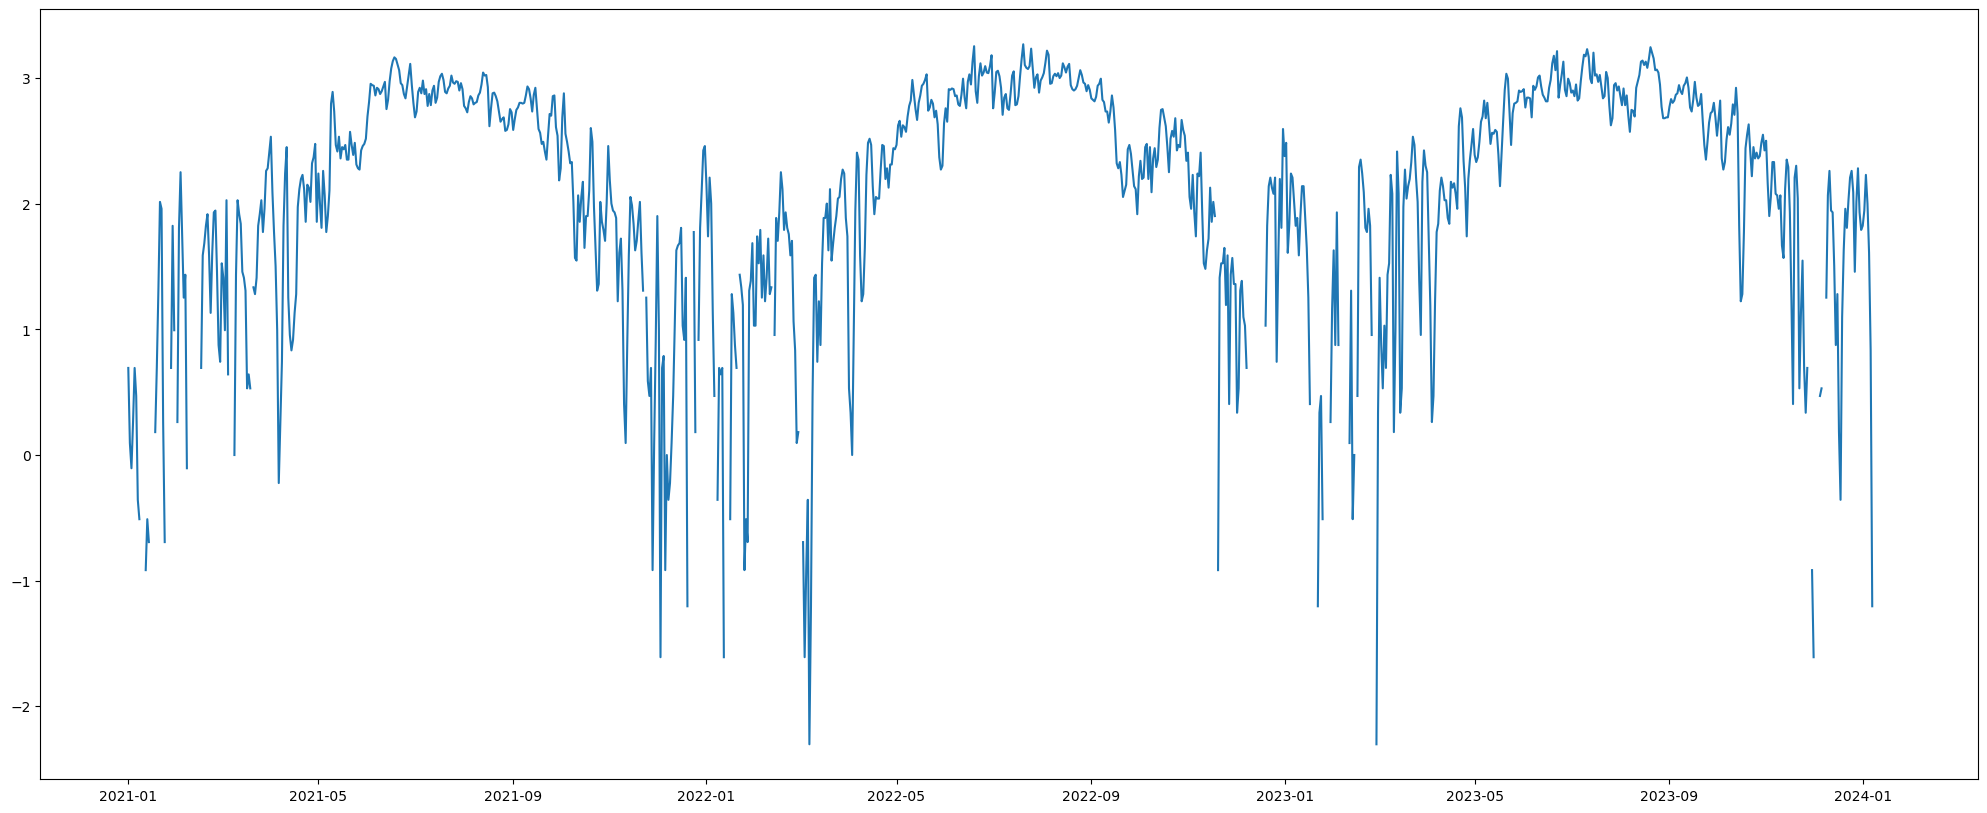

In [157]:
plt.figure(figsize=(25,10))
plt.plot(np.log(df['Wert']))
plt.show()


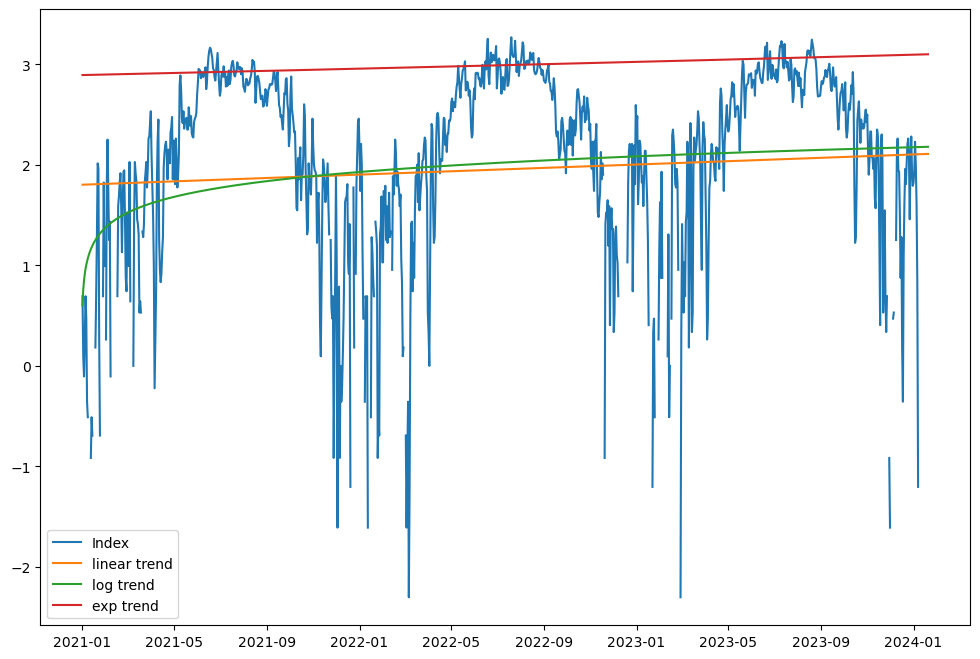

In [309]:
from sklearn.linear_model import LinearRegression

df1 = df.drop(['Station', 'Kategorie'], axis=1)
df1 = df1.reset_index(drop=True)

np.seterr(divide='ignore')
np.set_printoptions(threshold=np.inf)

y = np.log(df1['Wert']).ffill(axis=0)

with pd.option_context('mode.use_inf_as_na', True):
    y = y.fillna(1.00)

X = np.array(range(len(np.log(df1['Wert']))))

#print(y)

# Linear Trend
reg = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = reg.predict(X.reshape(-1,1))  

# Logarithmic trend
a_1,b_1 = np.polyfit(np.log(X+1), y, 1)
pred_log = a_1 * np.log(X+1) + b_1

# Exponential trend
#a_2,b_2 = np.polyfit(X+1, np.log(y), 1)
#pred_exp = np.exp(b_2) + np.exp( (X+1) * a_2)

plt.figure(figsize=(12,8))
plt.plot(np.log(df['Wert']), label="Index")
plt.plot(df['Wert'].index, pred_lin, label="linear trend")
plt.plot(df['Wert'].index, pred_log, label="log trend")
plt.plot(df['Wert'].index, pred_exp, label="exp trend")
plt.legend()
plt.show()

Zeitstempel
2021-01-01   -1.109493
2021-01-02   -1.707605
2021-01-03   -1.908551
2021-01-04   -1.541101
2021-01-05   -1.110593
                ...   
2024-01-04   -0.103141
2024-01-05   -0.495458
2024-01-06   -1.272262
2024-01-07   -3.309419
2024-01-18   -3.312444
Name: Wert, Length: 1044, dtype: float64


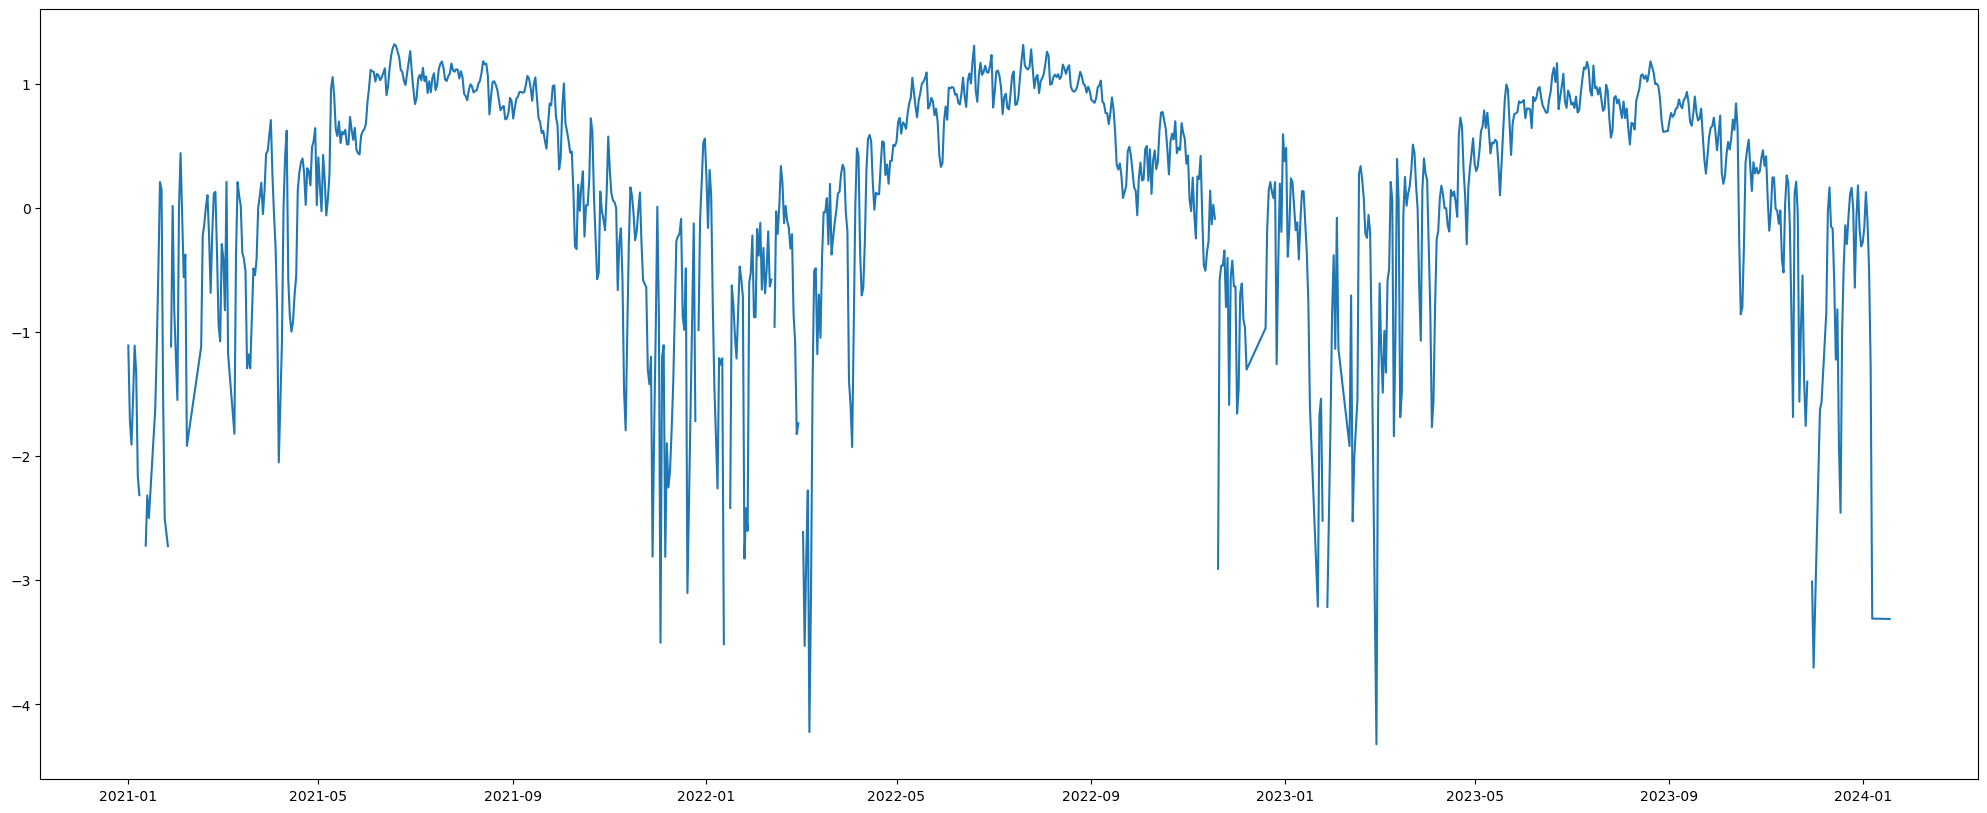

In [310]:
series = np.log(df['Wert']) - pred_lin
series = series.dropna()
print(series)

plt.figure(figsize=(25,10))
plt.plot(series)
plt.show()

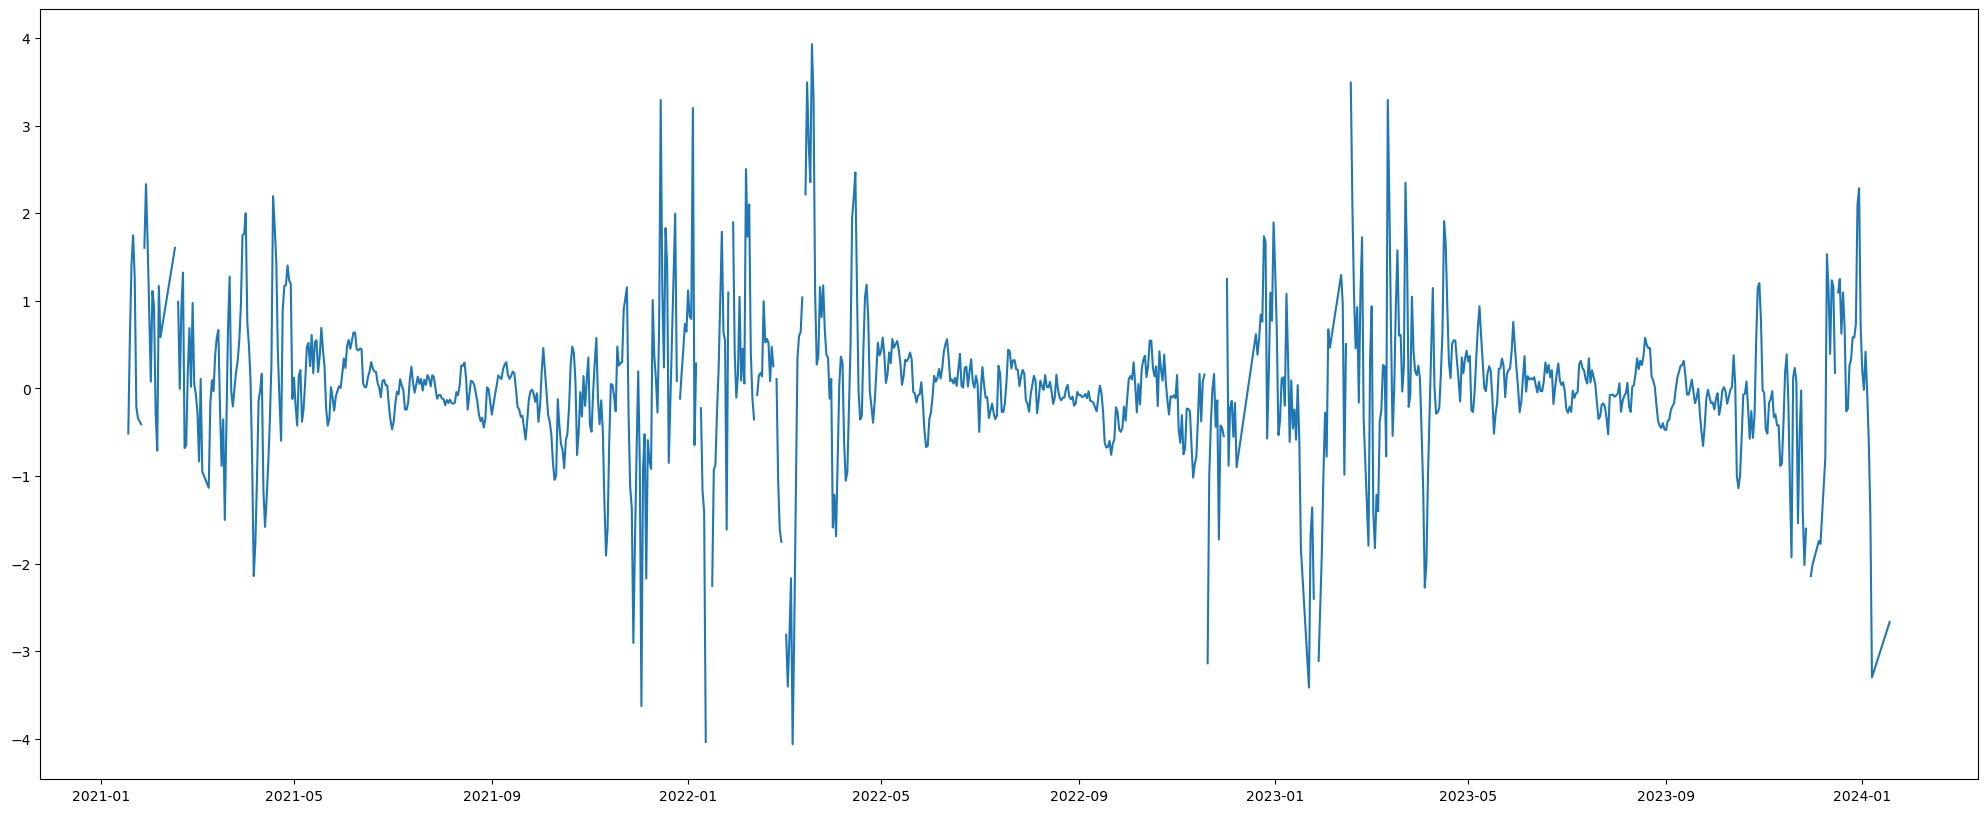

In [311]:
plt.figure(figsize=(25,10))
plt.plot(series - series.shift(12))
plt.show()

In [329]:
series_stationary = series - series.shift(12)
series_stationary = series_stationary.dropna()
series_stationary = series_stationary.replace([np.inf, -np.inf], 0)

result = adfuller(series_stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -11.623497
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [333]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
size = int(len(series_stationary) * 0.75)
train, test = series_stationary[0:size], series_stationary[size:len(series_stationary)]
test = test.reset_index()['Wert']
history = [x for x in train]
predictions = []


In [334]:
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


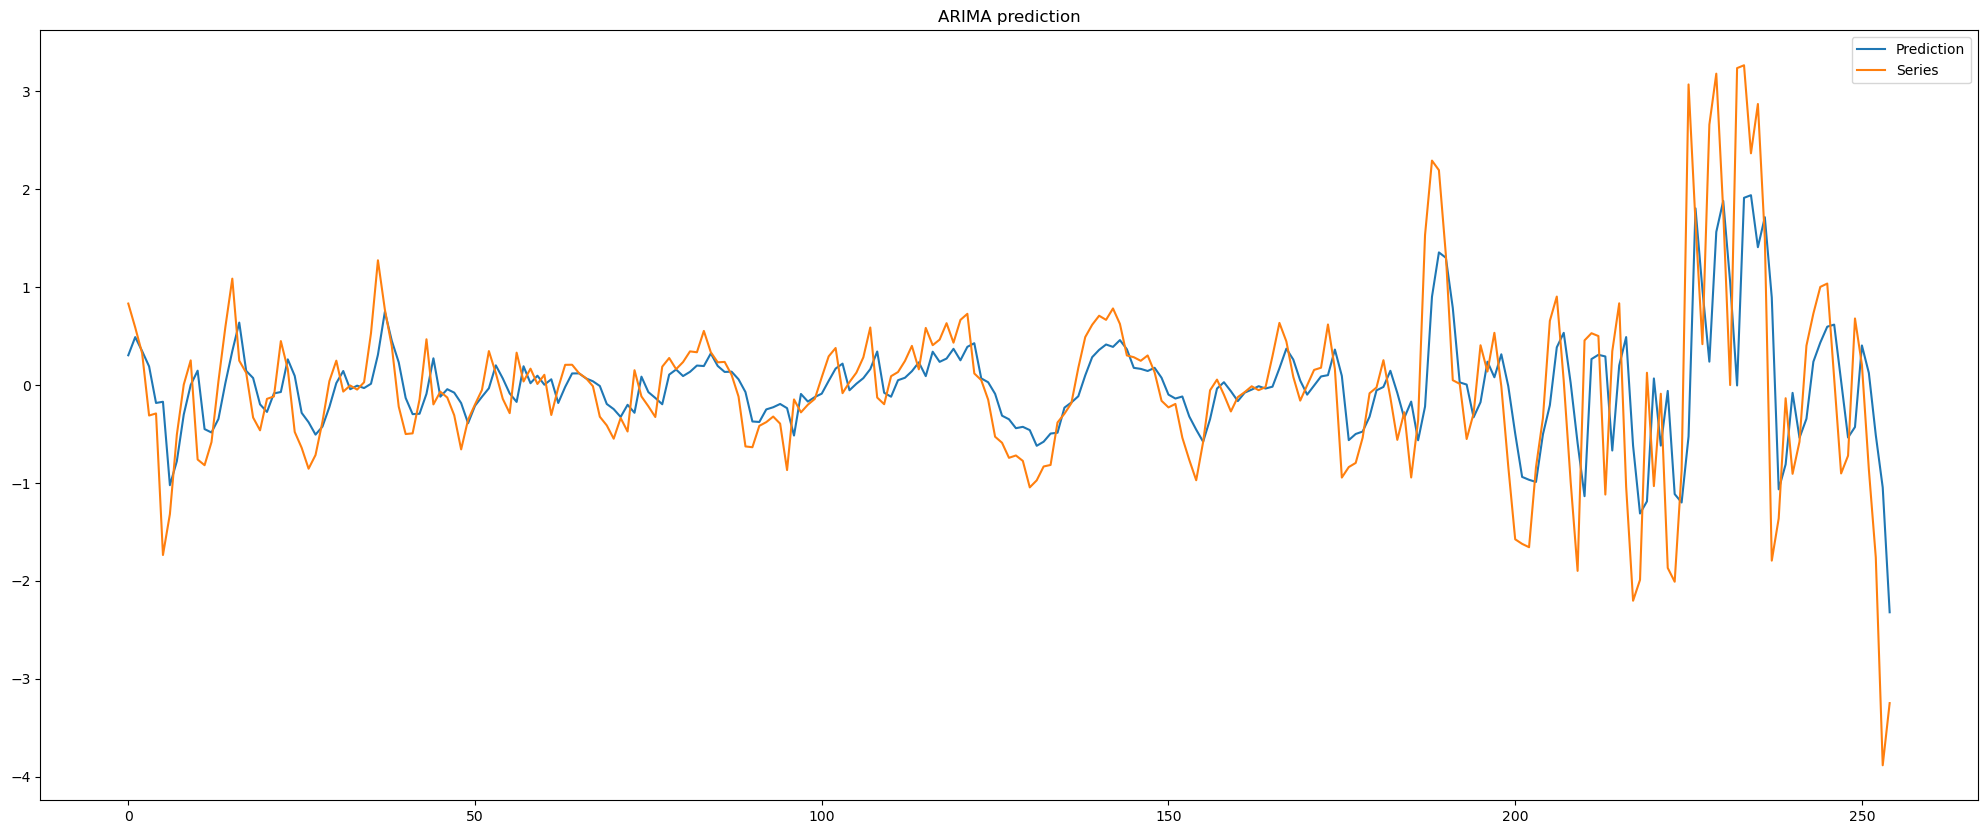

In [335]:
plt.figure(figsize=(25,10))
plt.plot(predictions, label="Prediction")
plt.plot(test, label="Series")
plt.title("ARIMA prediction")
plt.legend()
plt.show()


In [336]:
from sklearn.metrics import mean_squared_error
mean_squared_error(predictions, test)

0.4466688215966268

In [337]:
start_idx = 204
end_idx = 250
series = series_stationary.reset_index()['Wert']

for i in range(start_idx, end_idx) :
    series[i] =  series[i-12]

In [338]:
X_full = np.array(range(0, end_idx))
pred_lin = reg.predict(X_full.reshape(-1,1))  

In [339]:
from statsmodels.tsa.api import SARIMAX, AutoReg

history = [x for x in series[:start_idx]]
predictions = list()

for t in range(end_idx-start_idx):
    model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)

/home/dosmarcos/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


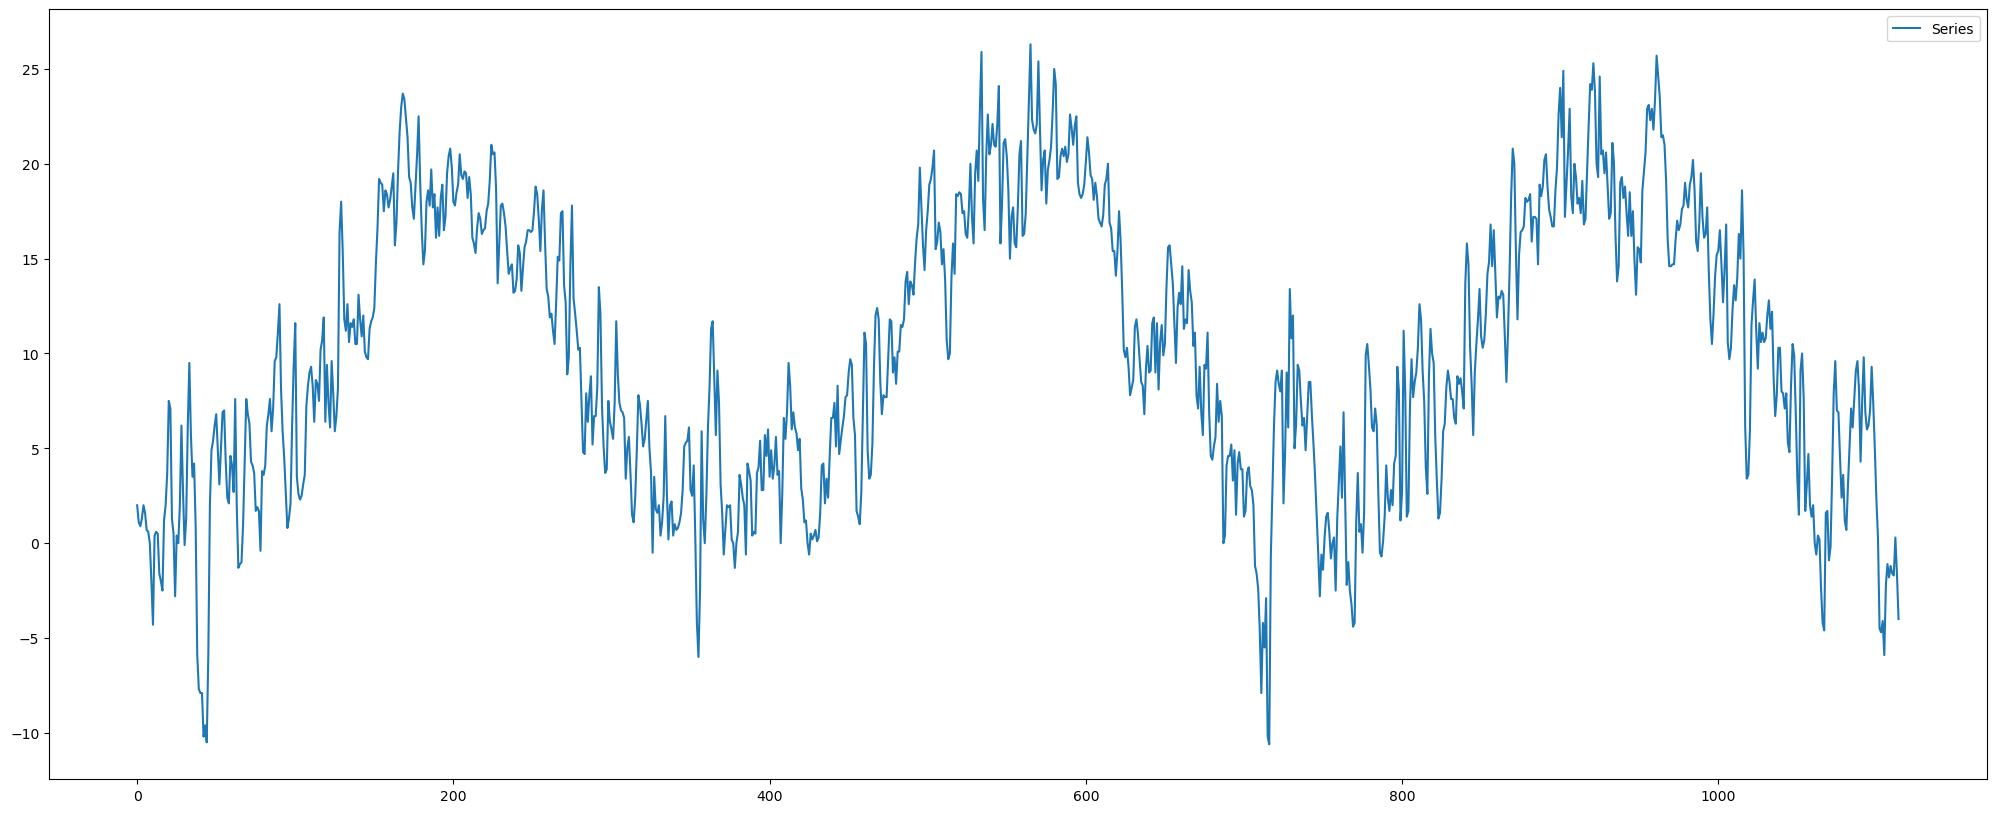

In [341]:

plt.figure(figsize=(25,10))
plt.plot(df.reset_index().Wert, label="Series")
#plt.plot(np.exp(series[204:]+pred_lin[204:]) + np.array(predictions), label="Recompose + SARIMA")
plt.legend()
plt.show()
